<h1><center> Représentation de séries temporelles en sac de mots et classification </center></h1>

L'approximation est une notion courante en apprentissage automatique, notamment concernant le surapprentissage et la généralisation. Par exemple, dans un arbre de décision, chaque noeud regarde si la valeur d'une variable est inférieure ou supérieure à un seuil donné : la décision est la même pour deux valeurs différentes du moment qu'elles sont toutes les deux soit inférieures soit supérieures à ce seuil.

Ce principe d'approximation a également été étudié pour la classification de séries temporelles. L'idée est de transformer une série temporelle (un vecteur ordonné de nombres réels) en un mot (un vecteur ordonné de symboles).

En pratique, les motifs caractéristiques de séries temporelles sont plus courts que la série temporelle entière. Le principe est donc d'extraire des sous séries temporelles avec une fenêtre glissante et de transformer chaque sous série en un mot. Le résultat final est donc une liste de mots. Néanmoins, pour la plupart des jeux de données utilisés, la position des motifs est beaucoup moins importante que la présence elle-même des motifs. Ce sont donc les fréquences des mots qui sont calculés.

En résumé, les algorithmes transformant des séries temporelles en sac de mots fonctionnent de la même manière suivante :
1. Extraction de sous séries temporelles avec une fenêtre glissante.
2. Approximation de chaque sous série temporelle en un mot.
3. Calcul de la fréquence de chaque mot.
4. Classification basée sur cette représentation.

Il existe des variantes pour chacune de ces étapes. Dans ce tutoriel, nous allons nous focaliser sur deux étapes en particulier :
(2) l'approximation de chaque sous série temporelle en un mot, et
(4) la classification basée sur cette représentation.

Il existe de grandes approches pour la transformation de chaque sous série temporelle en un mot : l'approximation dans le domaine temporel et l'approximation dans le domaine fréquentiel. Le tutoriel se décompose en deux parties pour chacune des approches, avec l'illustration de quelques algorithmes.

Pour ce faire, nous allons utiliser un paquet Python appelé `pyts` dédié à la classification de séries temporelles et mettant à disposition des implémentations de nombreux algorithmes. Le projet est hébergé sur [GitHub](https://github.com/johannfaouzi/pyts) et sa documentation sur [ReadTheDocs](https://pyts.readthedocs.io/en/stable/index.html).

Les paquets Python nécessaires pour ce tutoriel sont :
* `matplotlib`
* `numpy`
* `scipy`
* `numba`
* `joblib`
* `scikit-learn`
* `pyts`

On installe les paquets si nécessaire en exécutant la cellule suivante (supprimer le # pour supprimer le commentaire) :

In [1]:
# ! pip install pyts matplotlib

On importe toutes les fonctions et classes nécessaires pour ce tutoriel :

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from pyts.approximation import (
    PiecewiseAggregateApproximation, SymbolicAggregateApproximation, SymbolicFourierApproximation
)
from pyts.datasets import fetch_ucr_dataset
from pyts.classification import BOSSVS, KNeighborsClassifier, SAXVSM
from pyts.transformation import BagOfPatterns, BOSS
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

On télécharge ensuite le jeu de données utilisé dans ce tutoriel :

In [3]:
X_train, X_test, y_train, y_test = fetch_ucr_dataset('Trace', return_X_y=True)

Enfin, on indique quelques hyper-paramètres courrament utilisés dans les algorithmes :
* `window_size` : la taille de la fenêtre glissante
* `word_size` et `n_coefs` : la longueur des mots
* `n_bins` : le nombre de symboles (lettres) dans l'alphabet
* `strategy` : la manière de calculer les intervalles pour la discrétisation

## Domaine temporel

### Symbolic Aggregate Approximation (SAX)

Dans le domaine temporel, une série temporelle est approchée en deux temps :
1. La série est tout d'abord sous-échantillonnée (en prenant la valeur moyenne en général).
2. La série sous-échantillonnée est discrétisée.

La première étape est connue dans la littérature sous le nom de *Piecewise Aggregate Approximation (PAA)*. L'ensemble des deux étapes est connue sous le nom *Symbolic Aggregate approXimation (SAX)*.

Ces deux algorithmes sont implémentés dans les classes [pyts.approximation.PiecewiseAggregateApproximation](https://pyts.readthedocs.io/en/stable/generated/pyts.approximation.PiecewiseAggregateApproximation.html) et [pyts.approximation.SymbolicAggregateApproximation](https://pyts.readthedocs.io/en/stable/generated/pyts.approximation.SymbolicAggregateApproximation.html)

**Attention** : `pyts.approximation.SymbolicAggregateApproximation` n'effectue que la deuxième étape (la discrétisation). Pour effectuer les deux étapes, il faut créer une chaîne.

Le code suivant illustre l'utilisation de ces deux classes et la transformation obtenue pour la première série temporelle du jeu d'entraînement :

In [4]:
sax = Pipeline([
    ('paa', PiecewiseAggregateApproximation(window_size=11)),
    ('sax', SymbolicAggregateApproximation(strategy='normal'))
])
''.join(sax.transform(X_train[:1]).ravel())

'ccccdaaaaaabbcccccccccccc'

La fonction `plot_sax` illustre l'algorithme :

In [5]:
def plot_sax(clf, x):

    from scipy.stats import norm
    from pyts.utils import segmentation

    def _compute_paa():
        window_size, output_size = clf['paa']._check_params(n_timestamps)
        start, end, n_timestamps_new = segmentation(
            n_timestamps, window_size, clf['paa'].overlapping, output_size
        )
        x_paa = clf['paa'].transform(x.reshape(1, -1))[0]
        return x_paa, start, end - 1

    def _compute_bins():
        if strategy == 'normal':
            bins_edges = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])
        elif strategy == 'uniform':
            bins_edges = np.linspace(np.min(x_paa), np.max(x_paa), n_bins + 1)[1:-1]
        else:
            bins_edges = np.percentile(
                x_paa, np.linspace(0, 100, n_bins + 1)[1:-1]
            )
        return bins_edges
    
    x = np.asarray(x)
    n_timestamps = x.size
    n_bins = sax['sax'].n_bins
    strategy = sax['sax'].strategy

    x_paa, start, end = _compute_paa()
    bin_edges = _compute_bins()
    x_sax = clf.transform(x.reshape(1, -1))[0]
    
    plt.figure(figsize=(16, 6))
    plt.plot(x)
    plt.hlines(x_paa, start, end, color='r')
    plt.hlines(bin_edges, 0, x.size, color='C1', linestyles='--', linewidth=1.5, label=strategy)
    for i in range(start.size):
        plt.text(0.5 * (start[i] + end[i]), plt.ylim()[0] - 0.2 * (plt.ylim()[1] - plt.ylim()[0]),
                 x_sax[i], color='r', fontsize=16, ha='center')
    
    plt.show()

Par exemple, voici la transformation obtenue pour la première série temporelle du jeu d'entraînement :

In [6]:
sax = Pipeline([
    ('paa', PiecewiseAggregateApproximation(window_size=20)),
    ('sax', SymbolicAggregateApproximation(strategy='normal'))
])

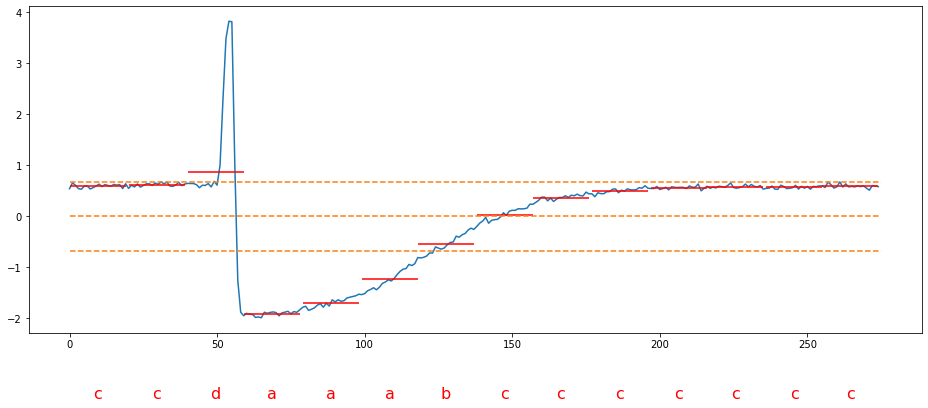

In [7]:
plot_sax(sax, X_train[0])

**Exercice** : Changez les valeurs de certains hyper-paramètres et observez comment la représentation obtenue change.

**Solution possible**

In [8]:
sax = Pipeline([
    ('paa', PiecewiseAggregateApproximation(window_size=4)),
    ('sax', SymbolicAggregateApproximation(strategy='normal'))
])
''.join(sax.transform(X_train[:1]).ravel())

'ccccccccccccddaaaaaaaaaaaaaaaaabbbbbbcccccccccccccccccccccccccccccccc'

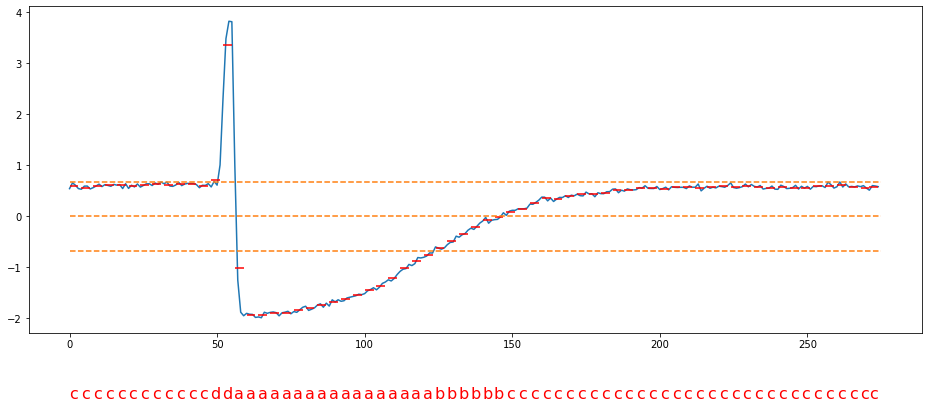

In [9]:
plot_sax(sax, X_train[0])

### Bag of Patterns (BOP)

L'algorithme *Bag of Patterns (BOP)* consiste à extraire des sous séries temporelles, puis à les transformer en mots avec l'algorithme *SAX*, et enfin calculer la fréquence de chaque mot. La classification à partir de cette nouvelle représentation peut se faire avec n'importe quel algorithme classique de classification, mais nous utiliserons ici la méthode des plus proches voisins (car il s'agit de l'algorithme utilisé dans la publication originale de cet algorithme).

L'algorithme est implémentée dans la classe [pyts.transformation.BagOfPatterns](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.BagOfPatterns.html). Le code suivant illustre une utilisation simple pour entraîner un modèle sur un jeu d'entraînement et l'évaluer sur un jeu de test :

In [10]:
bop = Pipeline([
    ('bop', BagOfPatterns(word_size=4, n_bins=4, sparse=False)),
    ('1nn', KNeighborsClassifier())
])
bop.fit(X_train, y_train)
bop.score(X_test, y_test)

0.84

La fonction `plot_bop` illustre la transformation obtenue par cet algorithme : 

In [11]:
def plot_bop(clf, x):
    
    from pyts.bag_of_words import BagOfWords
    from pyts.utils import windowed_view
    
    def get_bop_words():
        n_timestamps = x.size

        bow = BagOfWords(
            window_size=clf_.window_size, word_size=clf_.word_size,
            n_bins=clf_.n_bins, strategy=clf_.strategy,
            numerosity_reduction=False,
            window_step=clf_.window_step, norm_mean=clf_.norm_mean,
            norm_std=clf_.norm_std, overlapping=clf_.overlapping,
            alphabet=clf_.alphabet
        )
        window_size, word_size, window_step, _ = bow._check_params(n_timestamps)
        n_windows = (n_timestamps - window_size + window_step) // window_step

        X_bow = bow.fit_transform(x.reshape(1, -1), None)
        x_word = np.asarray(X_bow[0].split(' '))
        not_equal_idx = np.r_[True, x_word[1:] != x_word[:-1]]
        return x_word, not_equal_idx, window_size, word_size, window_step, n_windows

    if isinstance(clf, Pipeline):
        clf_ = clf['bop']
    else:
        clf_ = clf

    x = np.asarray(x)
    
    x_word, not_equal_idx, window_size, word_size, window_step, n_windows = get_bop_words()

    fig, axes = plt.subplots(3, 1, figsize=(16, 8), gridspec_kw={'hspace': 0.5})

    # Plot raw time series
    axes[0].plot(x)
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()
    
    axes[0].text(0, 1.04, r'(a)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[0].transAxes)

    # Plot BOP words
    for i, pos in enumerate(np.linspace(0, x.size - 1, n_windows, endpoint=False)):
        if clf_.numerosity_reduction:
            alpha = 1. if not_equal_idx[i] else 0.2
            fontweight = 'bold' if not_equal_idx[i] else 'normal'
        else:
            alpha = 1.
            fontweight = 'bold'
        axes[1].text(pos, 1.2 - (i % (word_size + 5)) / 5, x_word[i],
                     color='C0', alpha=alpha, fontsize=8, fontweight=fontweight)

    axes[1].set_xlim(xlim)
    axes[1].set_axis_off()
    axes[1].text(0., 1.26, '(b)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[1].transAxes)

    # Plot BOP histogram
    X_bop = clf_.transform(x.reshape(1, -1))
    x_bop = X_bop[0]

    vocabulary_length = len(clf_.vocabulary_)
    vocabulary = np.vectorize(clf_.vocabulary_.get)(np.arange(vocabulary_length))
    axes[2].bar(np.arange(np.sum(x_bop > 0)), x_bop[x_bop > 0])
    axes[2].set_xticks(np.arange(np.sum(x_bop > 0)))
    axes[2].set_xticklabels(vocabulary[x_bop > 0], rotation=90)
    axes[2].text(0, 1.04, '(c)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[2].transAxes)
    
    plt.show()

Par exemple, voici la transformation obtenue pour la première série temporelle du jeu d'entraînement :

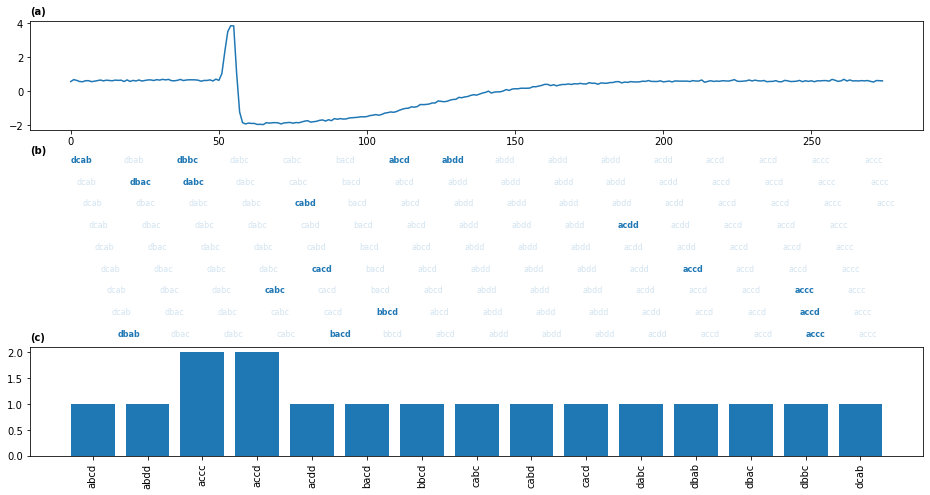

In [12]:
plot_bop(bop, X_train[0])

**Exercice** : Changez les valeurs de certains hyper-paramètres, observez comment la représentation obtenue change et regardez la performance prédictive obtenue. Si vous êtes familier avec `scikit-learn`, vous pouvez également essayer un autre algorithme de classification. 

**Solution possible**

In [13]:
from sklearn.linear_model import LogisticRegression

bop = Pipeline([
    ('bop', BagOfPatterns(word_size=5, sparse=False)),
    ('lr', LogisticRegression())
])
bop.fit(X_train, y_train)
bop.score(X_test, y_test)

0.95

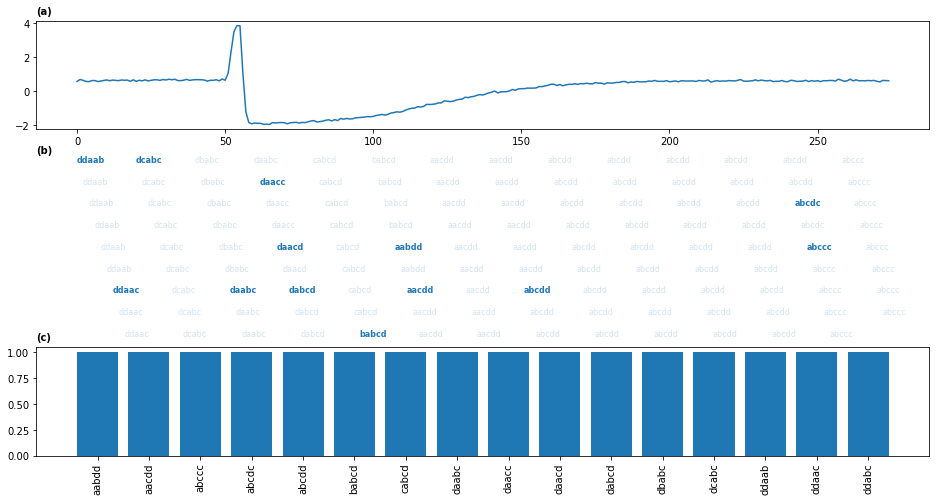

In [14]:
plot_bop(bop, X_train[0])

### Symbolic Aggregate Approximation in Vector Space Model (SAXVSM)

L'algorithme *Symbolic Aggregate Approximation in Vector Space Model (SAXVSM)* est inspiré du traitement du langage naturel, et plus particulièrement l'approche *term-frequency inverse-document-frequency (TF-IDF)*.
Les sacs de mots d'une même classe sont regroupés ensemble et forment un seul document. L'objectif est de trouver des mots qui sont spécifiques à chaque classe.
Pour ce faire, les fréquences de mots (*term frequencies*) vont être pondérées par l'inverse de leur fréquence dans les classes (*inverse document frequencies*).
Le principe derrière cette approche est intuitive : si un mot n'apparaît dans peu de classes, alors il lui est donné un poids plus élevé car il est discriminatif, tandis qu'un mot qui apparaît dans beaucoup de classes a un poids moins élevé car il est peu discriminatif.

L'algorithme est implémentée dans la classe [pyts.classification.SAXVSM](https://pyts.readthedocs.io/en/stable/generated/pyts.classification.SAXVSM.html). Le code suivant illustre une utilisation simple pour entraîner un modèle sur un jeu d'entraînement et l'évaluer sur un jeu de test :

In [15]:
saxvsm = SAXVSM(window_size=90, word_size=3, n_bins=4)
saxvsm.fit(X_train, y_train)
saxvsm.score(X_test, y_test)

0.63

La fonction `plot_saxvsm` illustre les vecteurs TF-IDF appris par l'algorithme :

In [16]:
def plot_saxvsm(clf):
    n_classes = len(clf.classes_)
    vocabulary_length = len(clf.vocabulary_)
    vocabulary = np.vectorize(clf.vocabulary_.get)(np.arange(vocabulary_length))
    
    fig, axes = plt.subplots(n_classes, 1, figsize=(16, n_classes * 3),
                             sharex=True, gridspec_kw={'hspace': 0.2})
    
    for i in range(n_classes):
        axes[i].bar(np.arange(vocabulary_length), clf.tfidf_[i], color=f'C{i}')
        axes[i].set_title(f'Vecteur TF-IDF pour la classe {clf.classes_[i]}')

    if vocabulary_length < 100:
        axes[-1].set_xticks(np.arange(len(vocabulary)))
        axes[-1].set_xticklabels(vocabulary, rotation=90)
    else:
        axes[-1].set_xticks([])

    plt.show()

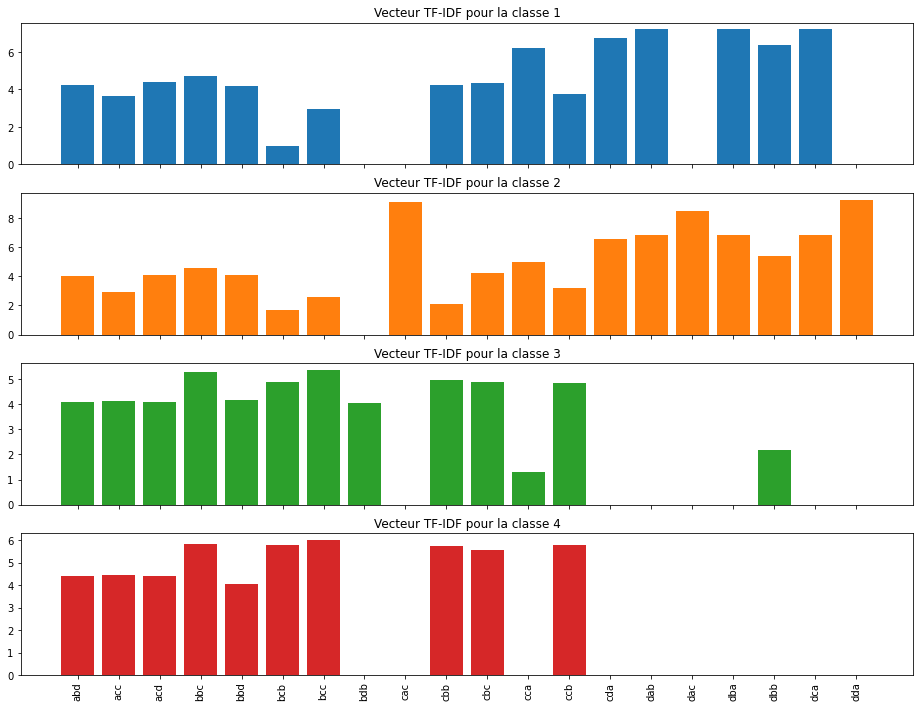

In [17]:
plot_saxvsm(saxvsm)

La fonction `saxvsm_cosine_similarity` calcule la similarité cosinus entre les vecteurs TF-IDF des classes et le vecteur des fréquences des mots d'une série temporelle. La classe prédite est la classe avec la similarité cosinus la plus élevée.

In [18]:
def saxvsm_cosine_similarity(clf, x):
    """Prints the cosine similarity between the tf-idf vector of each
    class and a univariate time series.
    
    Parameters
    ----------
    clf : SAXVSM
        A fitted instance of BOSSVS.
    
    x : array-like, shape = (n_timestamps,)
        A univariate time series.
    
    """
    x = np.asarray(x)
    cosine_similarity = clf.decision_function(x.reshape(1, -1)).ravel()
    string = '\n'.join(
        [
            f"Similarité cosinus avec la classe {class_} = {score:.6f}"
            for class_, score in zip(clf.classes_, cosine_similarity)
        ] + [
            f"La classe prédite est donc la classe "
            f"{clf.classes_[np.argmax(cosine_similarity)]}."
        ]
    )
    
    print(string) 

In [19]:
saxvsm_cosine_similarity(saxvsm, X_test[0])

Similarité cosinus avec la classe 1 = 0.582852
Similarité cosinus avec la classe 2 = 0.514026
Similarité cosinus avec la classe 3 = 0.840264
Similarité cosinus avec la classe 4 = 0.859223
La classe prédite est donc la classe 4.


**Exercice** : Modifiez les valeurs de certains hyper-paramètres, affichez les vecteurs TF-IDF calculés et évaluer la performance prédictive sur le jeu de test.

**Solution possible**

In [20]:
saxvsm = SAXVSM()
saxvsm.fit(X_train, y_train)
saxvsm.score(X_test, y_test)

0.98

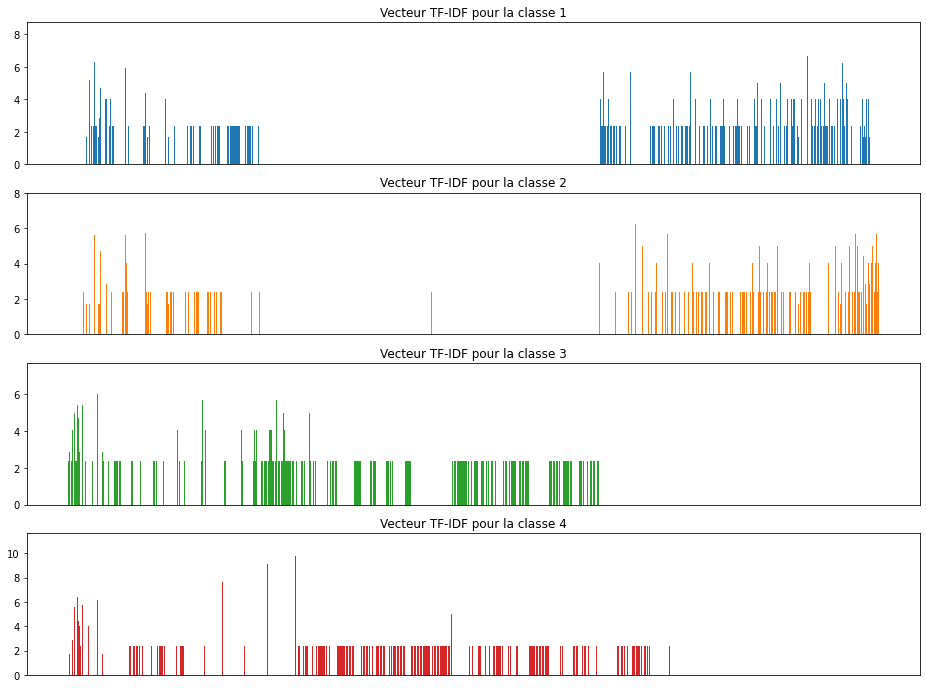

In [21]:
plot_saxvsm(saxvsm)

## Domaine fréquentiel

Si $x = (x_0, \ldots, x_{N-1}) \in \mathbb{C}^n$ est un vecteur de taille $n$, sa transformée de Fourier discrète est un vecteur $s = (s_0, \ldots, s_{N-1})  \in \mathbb{C}^n$ également de taille $n$ défini par :

$$
s_k = \sum_{n=0}^{N-1} x_n \cdot \mathrm e^{-2\mathrm i \pi k \frac nN} \qquad \text{pour} \qquad  0 \leqslant k < N
$$

Les premiers coefficients correspondent aux fréquences les plus faibles (donc au signal en général), tandis que les derniers coefficients correspondent aux fréquences les plus élevées (donc au bruit en général).
Il est donc possible de garder uniquement un sous-ensemble des coefficients de Fourier (les premeirs en général) pour approcher une série temporelle.
C'est sur ce principe que reposent les algorithmes présentés dans cette section.

### Symbolic Fourier Approximation (SFA)

L'algorithme *Symbolic Fourier Approximation (SFA)* consiste à calculer les premiers coefficients de Fourier d'une série temporelle, puis de discrétiser ces coefficients afin d'obtenir un mot.

L'algorithme est implémentée dans la classe [pyts.approximation.SymbolicFourierApproximation](https://pyts.readthedocs.io/en/stable/generated/pyts.approximation.SymbolicFourierApproximation.html).
Le code suivant illustre une utilisation simple pour transformer les séries temporelles d'un jeu de données en mots avec cet algorithme :

In [22]:
sfa = SymbolicFourierApproximation(n_coefs=10, drop_sum=True)
sfa.fit(X_train, y_train)
''.join(sfa.transform(X_train)[0])

'cccaaaacdc'

La fonction `plot_sfa` illustre cet algorithme :

In [23]:
def plot_sfa(clf, x):
    
    def get_idft(x_dft, n_timestamps):
        n_coefs = x_dft.size
        if n_coefs % 2 == 0:
            real_idx = np.arange(1, n_coefs, 2)
            imag_idx = np.arange(2, n_coefs, 2)
            x_dft_new = np.r_[
                x_dft[:1], x_dft[real_idx] + 1j * np.r_[x_dft[imag_idx], 0]
            ]
        else:
            real_idx = np.arange(1, n_coefs, 2)
            imag_idx = np.arange(2, n_coefs + 1, 2)
            x_dft_new = np.r_[
                x_dft[:1], x_dft[real_idx] + 1j * x_dft[imag_idx]
            ]
        return np.fft.irfft(x_dft_new, n_timestamps)

    
    x = np.asarray(x)
    X = x.reshape(1, -1)

    # Transformations
    x_dft = clf._pipeline['dft'].transform(X)[0]
    n_coefs = x_dft.size
    x_sfa = clf.transform(X)[0]
    x_idft = get_idft(x_dft, x.size)
    
    # Plot figure
    fig, axes = plt.subplots(
        3, 1, figsize=(12, 6),
        gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.5}
    )

    # Plot raw time series
    axes[0].plot(x)
    axes[0].text(0, 1.04, '(a)', fontweight='bold',
                 va='bottom', ha='left', transform=axes[0].transAxes)

    # Plot approximated time series with DFT
    axes[1].plot(x_idft)
    axes[1].text(0, 1.04, '(b)', fontweight='bold',
                 va='bottom', ha='left', transform=axes[1].transAxes)
    axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_ylim(axes[0].get_ylim())

    # Plot bin edges
    for i in range(n_coefs):
        axes[2].hlines(sfa.bin_edges_[i], i, i + 1, color='k')

    # Plot vertical lines to separate DFT coefficients
    ylim = np.asarray(axes[2].get_ylim()) * 1.2
    axes[2].vlines(np.arange(0, n_coefs + 1), ylim[0], ylim[1], color='k')

    # Fill rectangles with colors as a legend
    for i in range(n_coefs):
        for k, color in enumerate(('C4', 'C9', 'C8', 'C5')):
            y1 = ylim[0] if k == 0 else sfa.bin_edges_[i, k - 1]
            y2 = ylim[1] if k == clf.n_bins - 1 else sfa.bin_edges_[i, k]
            axes[2].fill_between([i, i + 1], y1, y2, color=color, alpha=0.25)
    axes[2].set_xticks(np.arange(0.5, n_coefs + 0.5))
    axes[2].set_xlabel('Discrete Fourier Transform coefficients', fontsize=8, labelpad=0)
    axes[2].set_xticklabels([])
    axes[2].legend(handles=[
        Patch(facecolor='C4', edgecolor='k', label='a', alpha=0.25),
        Patch(facecolor='C9', edgecolor='k', label='b', alpha=0.25),
        Patch(facecolor='C8', edgecolor='k', label='c', alpha=0.25),
        Patch(facecolor='C7', edgecolor='k', label='d', alpha=0.25),
    ], loc=(1.01, 0.55), fontsize=9)

    # Display DFT coefficients
    ylim_min, ylim_max = axes[2].get_ylim()
    for j in range(n_coefs):
        axes[2].text(0.5 + j, ylim_max + 0.05 * (ylim_max - ylim_min), '{:.3f}'.format(x_dft[j]),
                     color='C0', ha='center', va='center', fontsize=12)

    # Display SFA words
    for j in range(n_coefs):
        axes[2].text(0.5 + j, ylim_min - 0.2 * (ylim_max - ylim_min), '{}'.format(x_sfa[j]),
                     color='C0', ha='center', va='center', fontsize=20)

    axes[2].text(0, 1.02, '(c)', fontweight='bold',
                 va='bottom', ha='left', transform=axes[2].transAxes)
    
    plt.show()

Par exemple, voici la transformation obtenue pour la première série temporelle du jeu d'entraînement :

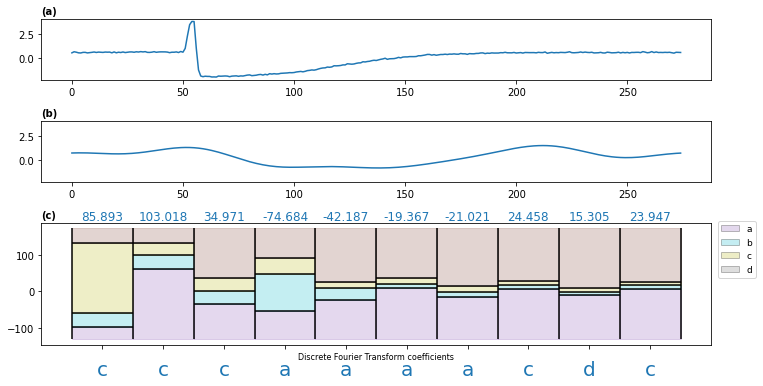

In [24]:
plot_sfa(sfa, X_train[0])

### Bag of Symbolic Fourier Approximation Symbols (BOSS)

L'algorithme *Bag of Symbolic Fourier Approximation Symbols (BOSS)* est assez similaire à l'algorithme *Bag of Patterns*, mais avec deux différences :
* Chaque sous série temporelle est transformée en mot avec l'algorithme SFA au lieu de SAX.
* La métrique utilisée dans l'algorithme des plus proches voisins est une version modifiée de la distance euclidienne : seul les mots présents dans la série temporelle de référence sont pris en compte.

L'algorithme est implémentée dans la classe [pyts.transformation.BOSS](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.BOSS.html). Le code suivant illustre une utilisation simple pour entraîner un modèle sur un jeu d'entraînement et l'évaluer sur un jeu de test :

In [25]:
boss = Pipeline([
    ('boss', BOSS(word_size=3, n_bins=4, sparse=False)),
    ('1nn', KNeighborsClassifier(metric='boss'))
])
boss.fit(X_train, y_train)
boss.score(X_test, y_test)

0.74

La fonction `plot_boss` illustre l'algorithme BOSS :

In [26]:
def plot_boss(clf, x):
    """
    Parameters
    ----------
    clf : BOSSVS
        A fitted instance of BOSSVS.

    x : array-like, shape = (n_timestamps, )
        A univariate time series.

    """

    from pyts.utils import windowed_view
    
    def get_sfa_words():
        
        X_windowed = windowed_view(x.reshape(1, -1), window_size, window_step)
        X_windowed = X_windowed.reshape(n_windows, window_size)

        sfa = SymbolicFourierApproximation(
            n_coefs=clf_.word_size, n_bins=clf_.n_bins, strategy=clf_.strategy,
            drop_sum=clf_.drop_sum, anova=clf_.anova, norm_mean=clf_.norm_mean,
            norm_std=clf_.norm_std, alphabet=clf_.alphabet
        )
        X_sfa = sfa.fit_transform(X_windowed, None)

        X_word = np.asarray([''.join(X_sfa[i]) for i in range(n_windows)])

        X_word = X_word.reshape(1, n_windows)
        not_equal_idx = np.c_[np.full(1, True), X_word[:, 1:] != X_word[:, :-1]]
        return X_word[0], not_equal_idx[0]

    if isinstance(clf, Pipeline):
        clf_ = clf['boss']
    else:
        clf_ = clf

    x = np.asarray(x)
    n_timestamps = x.size
    window_size, window_step = clf_._check_params(n_timestamps)
    n_windows = (n_timestamps - window_size + window_step) // window_step

    fig, axes = plt.subplots(3, 1, figsize=(16, 8), gridspec_kw={'hspace': 0.5})

    # Plot raw time series
    axes[0].plot(x)
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    axes[0].text(0, 1.04, r'(a)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[0].transAxes)

    # Plot SFA words
    x_word, not_equal_idx = get_sfa_words()

    for i in range(n_windows):
        if clf_.numerosity_reduction:
            alpha = 1. if not_equal_idx[i] else 0.2
            fontweight = 'bold' if not_equal_idx[i] else 'normal'
        else:
            alpha = 1.
            fontweight = 'bold'
        axes[1].text(i, 1.2 - (i % (clf_.word_size + 5)) / 5, x_word[i],
                     color='C0', alpha=alpha, fontsize=8, fontweight=fontweight)

    axes[1].set_xlim(xlim)
    axes[1].set_axis_off()

    axes[1].text(0., 1.26, '(b)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[1].transAxes)

    # Plot BOSS histogram
    X_boss = clf_.transform(x.reshape(1, -1))
    x_boss = X_boss[0]

    vocabulary_length = len(clf_.vocabulary_)
    vocabulary = np.vectorize(clf_.vocabulary_.get)(np.arange(x_boss.size))
    axes[2].bar(np.arange(np.sum(x_boss > 0)), x_boss[x_boss > 0])
    axes[2].set_xticks(np.arange(np.sum(x_boss > 0)))
    axes[2].set_xticklabels(vocabulary[x_boss > 0], rotation=90)

    axes[2].text(0, 1.04, '(c)', fontweight='bold', va='bottom',
                 ha='left', transform=axes[2].transAxes)
    
    plt.show()

Par exemple, voici la transformation obtenue pour la première série temporelle du jeu d'entraînement :

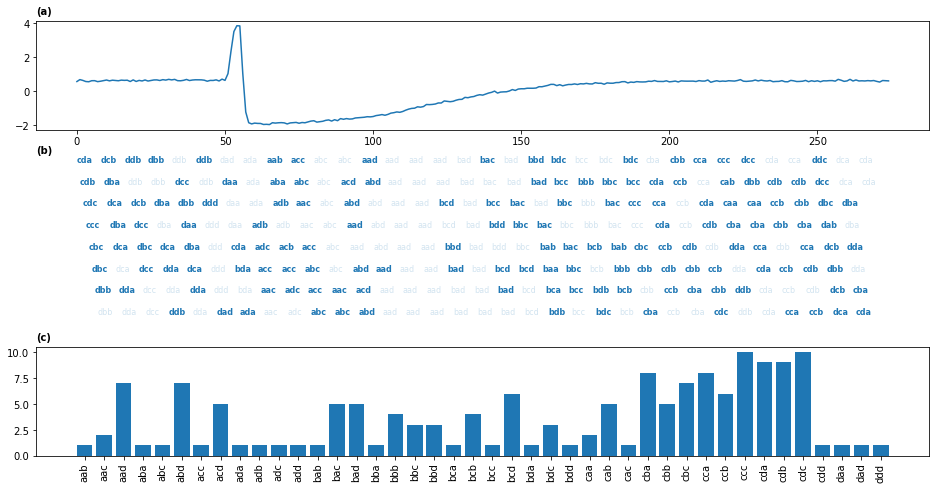

In [27]:
plot_boss(boss, X_train[0])

**Exercice** : Changez les valeurs de certains hyper-paramètres, observez comment la représentation obtenue change et regardez la performance prédictive obtenue. Si vous êtes familier avec `scikit-learn`, vous pouvez également essayer un autre algorithme de classification. 

**Solution possible**

In [28]:
from sklearn.tree import DecisionTreeClassifier

boss = Pipeline([
    ('boss', BOSS(word_size=4, n_bins=4, sparse=False)),
    ('tree', DecisionTreeClassifier())
])
boss.fit(X_train, y_train)
boss.score(X_test, y_test)

0.93

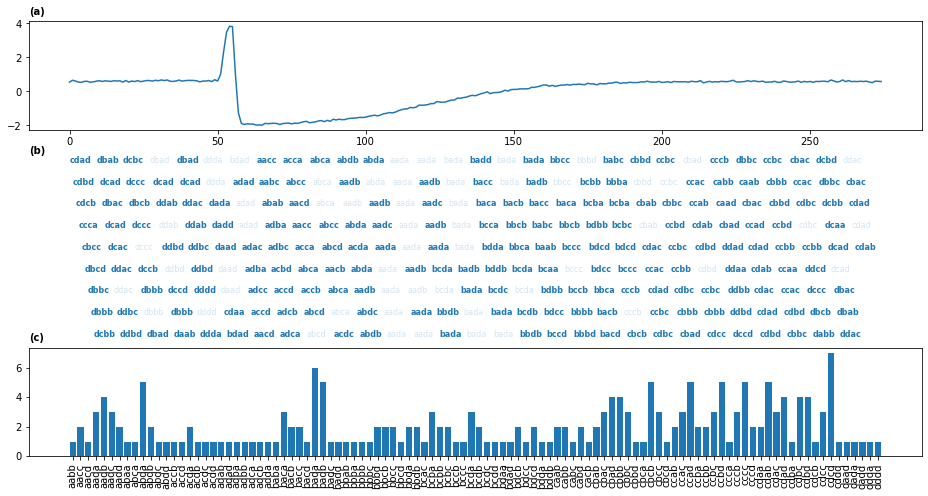

In [29]:
plot_boss(boss, X_train[0])

### Bag of Symbolic Fourier Approximation Symbols in Vector Space (BOSSVS)

L'idée de l'algorithme *Bag of Symbolic Fourier Approximation Symbols in Vector Space (BOSSVS)* est similaire à celle de l'algorithme *SAXVSM* : chaque classe est représentée par un vecteur représentant les fréquences (pondérées) des mots dans les séries temporelles de cette classe. La prédiction pour une nouvelle série temporelle correspond à la classe dont le vecteur est le plus similaire au vecteur de la série temporelle.

L'algorithme est implémentée dans la classe [pyts.classification.BOSSVS](https://pyts.readthedocs.io/en/stable/generated/pyts.classification.BOSSVS.html). Le code suivant illustre une utilisation simple pour entraîner un modèle sur un jeu d'entraînement et l'évaluer sur un jeu de test :

In [30]:
bossvs = BOSSVS(window_size=30, word_size=3, n_bins=4)
bossvs.fit(X_train, y_train)
bossvs.score(X_test, y_test)

0.8

La fonction `plot_bossvs` illustre les vecteurs appris pour chaque classe :

In [31]:
def plot_bossvs(clf):
    n_classes = len(clf.classes_)
    vocabulary_length = len(clf.vocabulary_)
    vocabulary = np.vectorize(clf.vocabulary_.get)(np.arange(vocabulary_length))
    
    fig, axes = plt.subplots(n_classes, 1, figsize=(16, n_classes * 3),
                             sharex=True, gridspec_kw={'hspace': 0.2})
    
    for i in range(n_classes):
        axes[i].bar(np.arange(vocabulary_length), clf.tfidf_[i], color=f'C{i}')
        axes[i].set_title(f'Vecteur TF-IDF pour la classe {clf.classes_[i]}')

    if vocabulary_length < 100:
        axes[-1].set_xticks(np.arange(len(vocabulary)))
        axes[-1].set_xticklabels(vocabulary, rotation=90)
    else:
        axes[-1].set_xticks([])
    
    plt.show()

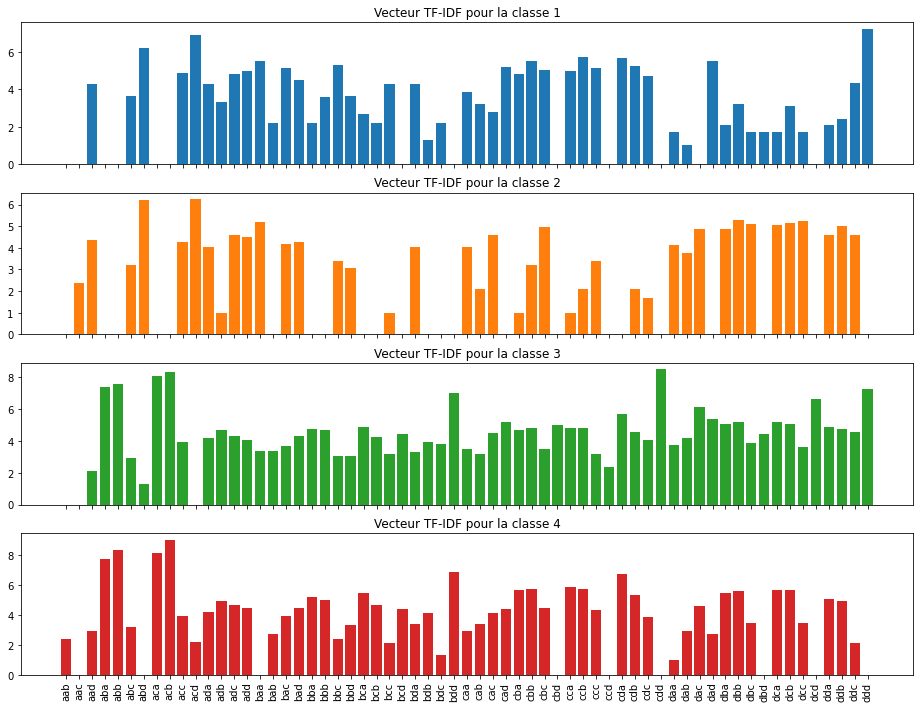

In [32]:
plot_bossvs(bossvs)

La fonction `bossvs_cosine_similarity` calcule la similarité cosinus entre les vecteurs TF-IDF des classes et le vecteur des fréquences des mots d'une série temporelle. La classe prédite est la classe avec la similarité cosinus la plus élevée.

In [33]:
def bossvs_cosine_similarity(clf, x):
    """Prints the cosine similarity between the tf-idf vector of each
    class and a univariate time series.
    
    Parameters
    ----------
    clf : BOSSVS
        A fitted instance of BOSSVS.
    
    x : array-like, shape = (n_timestamps,)
        A univariate time series.
    
    """
    x = np.asarray(x)
    cosine_similarity = clf.decision_function(x.reshape(1, -1)).ravel()
    string = '\n'.join(
        [
            f"Similarité cosinus avec la classe {class_} = {score:.6f}"
            for class_, score in zip(clf.classes_, cosine_similarity)
        ] + [
            f"La classe prédite est donc la classe "
            f"{clf.classes_[np.argmax(cosine_similarity)]}."
        ]
    )
    
    print(string) 

In [34]:
bossvs_cosine_similarity(bossvs, X_test[0])

Similarité cosinus avec la classe 1 = 0.403023
Similarité cosinus avec la classe 2 = 0.550710
Similarité cosinus avec la classe 3 = 0.745054
Similarité cosinus avec la classe 4 = 0.694506
La classe prédite est donc la classe 3.


**Exercice** : Modifiez les valeurs de certains hyper-paramètres, affichez les vecteurs TF-IDF calculés et évaluer la performance prédictive sur le jeu de test.

**Solution possible**

In [35]:
bossvs = BOSSVS(window_size=60, word_size=4, n_bins=4)
bossvs.fit(X_train, y_train)
bossvs.score(X_test, y_test)

0.94

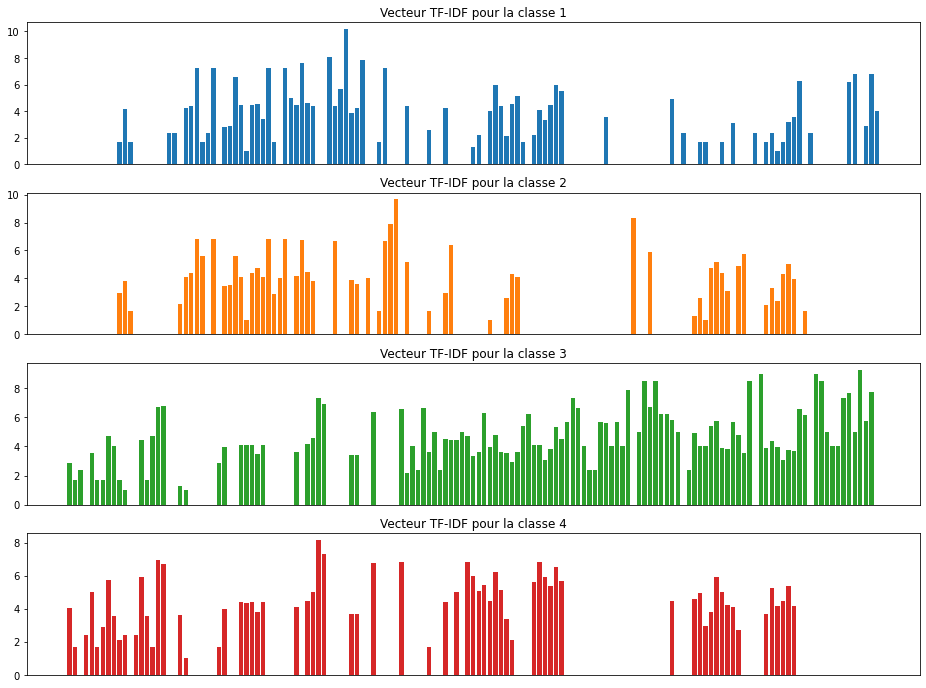

In [36]:
plot_bossvs(bossvs)

# Modèles ensemblistes

En pratique, utiliser un seul modèle (c'est-à-dire une seule combinaison d'hyper-paramètres) peut limiter la performance prédictive. Pour y remédier, il est souvent conseillé d'utiliser un modèle ensembliste (c'est-à-dire un ensemble de modèles avec différentes combinaisons d'hyper-paramètres).

Le code suivant illustre un ensemble de modèles BOSSVS avec différentes tailles de fenêtre glissante et différentes longueurs de mots :

In [37]:
bossvs_ensemble = VotingClassifier([
    (f'bossvs_{window_size}_{word_size}', BOSSVS(word_size=word_size, window_size=window_size))
    for window_size in range(10, 30, 5)
    for word_size in range(3, 7)
])

bossvs_ensemble.fit(X_train, y_train)
bossvs_ensemble.score(X_test, y_test)

0.81

**Exercice** : Créer un autre modèle ensembliste constitué de plusieurs algorithmes vus au cours de ce tutoriel. 

**Solution possible**

In [38]:
bossvs_ensemble = VotingClassifier([
    (f'bossvs_{window_size}_{word_size}', BOSSVS(word_size=word_size, window_size=window_size))
    for window_size in range(40, 160, 5)
    for word_size in range(4, 6)
])

bossvs_ensemble.fit(X_train, y_train)
bossvs_ensemble.score(X_test, y_test)

0.98